### M.1371 : Technical characteristics for an automatic identification system using time division multiple access in the VHF maritime mobile frequency band (Rec. ITU-R M.1371-5 )

https://www.itu.int/rec/R-REC-M.1371-5-201402-I/en

| Identifier No. | Vessel Type                                                  |
| -------------- | ------------------------------------------------------------ |
| 50             | Special craft                                                |
| 51             | Pilot vessel                                                 |
| 52             | Search and rescue vessels                                    |
| 53             | Tugs                                                         |
| 54             | Port tenders                                                 |
| 55             | Vessels with anti-pollution facilities or equipment          |
| 56             | Law enforcement vessels                                      |
| 57             | Spare – for assignments to local vessels                     |
| 58             | Spare – for assignments to local vessels                     |
| 59             | Medical transports (as defined in the 1949 Geneva Conventions and Additional Protocols) |
| 60             | Ships and aircraft of States not parties to an armed conflict |
| 0X             | Fishing vessels                                              |
| 1X             | Carrying dangerous goods (DG), harmful substances (HS), or marine pollutants (MP), or IMO hazard or pollutant category X |
| 2X             | Towing vessels                                               |
| 3X             | Vessels engaged in dredging or underwater operations         |
| 4X             | Vessels engaged in diving operations                         |
| 5X             | Reserved for future use                                      |
| 6X             | Passenger ships                                              |
| 7X             | Cargo ships                                                  |
| 8X             | Tankers                                                      |
| 9X             | Other types of ships                                         |

Table 53: Identifiers to be used by ships to report their type (Rec. ITU-R M.1371-5)

In [0]:
# Read the spark dataframe
df_ais_june = spark.read.table("ais.june")

In [0]:
df_ais_june.printSchema()

root
 |-- MMSI: string (nullable = true)
 |-- BaseDateTime: timestamp (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LON: double (nullable = true)
 |-- SOG: double (nullable = true)
 |-- COG: double (nullable = true)
 |-- Heading: double (nullable = true)
 |-- VesselName: string (nullable = true)
 |-- IMO: string (nullable = true)
 |-- CallSign: string (nullable = true)
 |-- VesselType: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- Length: double (nullable = true)
 |-- Width: double (nullable = true)
 |-- Draft: double (nullable = true)
 |-- Cargo: string (nullable = true)
 |-- TranscieverClass: string (nullable = true)
 |-- filename: string (nullable = true)



In [0]:
from pyspark.sql import functions as F
from scipy import stats

# Extract hour from the timestamp
df_ais_june = df_ais_june.withColumn('hour', F.hour(F.col('BaseDateTime')))

# Classify hours into 'Daylight' and 'Night-time'
df_ais_june = df_ais_june.withColumn('time_of_day', F.when((F.col('hour') >= 6) & (F.col('hour') < 20), 'Daylight').otherwise('Night-time'))

# Compute average SOG for each time of day
avg_sog_daytime = df_ais_june.filter(F.col('time_of_day') == 'Daylight').agg(F.avg('SOG')).first()[0]
avg_sog_nighttime = df_ais_june.filter(F.col('time_of_day') == 'Night-time').agg(F.avg('SOG')).first()[0]

print("Average SOG during Daylight: ", avg_sog_daytime)
print("Average SOG during Night-time: ", avg_sog_nighttime)

# Perform two-sample t-test
daytime_sog = df_ais_june.filter(F.col('time_of_day') == 'Daylight').select('SOG').rdd.flatMap(lambda x: x).collect()
nighttime_sog = df_ais_june.filter(F.col('time_of_day') == 'Night-time').select('SOG').rdd.flatMap(lambda x: x).collect()

t_stat, p_val = stats.ttest_ind(daytime_sog, nighttime_sog, equal_var=False)

print("T-statistic: ", t_stat)
print("P-value: ", p_val)

Average SOG during Daylight:  2.6574373851862787
Average SOG during Night-time:  2.579570121093527
T-statistic:  94.34081430771612
P-value:  0.0


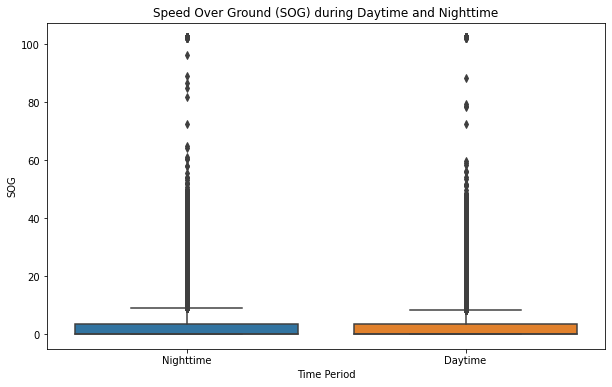

In [0]:
from pyspark.sql.functions import hour
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column to specify whether it's daytime or nighttime
df_ais_june = df_ais_june.withColumn('TimePeriod', F.when((hour(df_ais_june.BaseDateTime) >= 6) & (hour(df_ais_june.BaseDateTime) < 18), 'Daytime').otherwise('Nighttime'))

# Sample a subset of the data for visualization (e.g., 1%)
df_sample = df_ais_june.sample(False, 0.01)

# Convert to pandas DataFrame for visualization
df_sample_pd = df_sample.select('TimePeriod', 'SOG').toPandas()

# Create boxplot for SOG during Daytime and Nighttime
plt.figure(figsize=(10,6))
sns.boxplot(x='TimePeriod', y='SOG', data=df_sample_pd)
plt.title('Speed Over Ground (SOG) during Daytime and Nighttime')
plt.ylabel('SOG')
plt.xlabel('Time Period')
plt.show()

In [0]:
from pyspark.sql import functions as F
from scipy import stats

# Filter data for SOG > 0
df_ais_june = df_ais_june.filter(F.col('SOG') > 0)

# Extract hour from the timestamp
df_ais_june = df_ais_june.withColumn('hour', F.hour(F.col('BaseDateTime')))

# Classify hours into 'Daylight' and 'Night-time'
df_ais_june = df_ais_june.withColumn('time_of_day', F.when((F.col('hour') >= 6) & (F.col('hour') < 20), 'Daylight').otherwise('Night-time'))

# Compute average SOG for each time of day
avg_sog_daytime = df_ais_june.filter(F.col('time_of_day') == 'Daylight').agg(F.avg('SOG')).first()[0]
avg_sog_nighttime = df_ais_june.filter(F.col('time_of_day') == 'Night-time').agg(F.avg('SOG')).first()[0]

print("Average SOG during Daylight: ", avg_sog_daytime)
print("Average SOG during Night-time: ", avg_sog_nighttime)

# Perform two-sample t-test
daytime_sog = df_ais_june.filter(F.col('time_of_day') == 'Daylight').select('SOG').rdd.flatMap(lambda x: x).collect()
nighttime_sog = df_ais_june.filter(F.col('time_of_day') == 'Night-time').select('SOG').rdd.flatMap(lambda x: x).collect()

t_stat, p_val = stats.ttest_ind(daytime_sog, nighttime_sog, equal_var=False)

print("T-statistic: ", t_stat)
print("P-value: ", p_val)

Average SOG during Daylight:  6.210523247055501
Average SOG during Night-time:  6.142418828277728
T-statistic:  39.67958316149535
P-value:  0.0


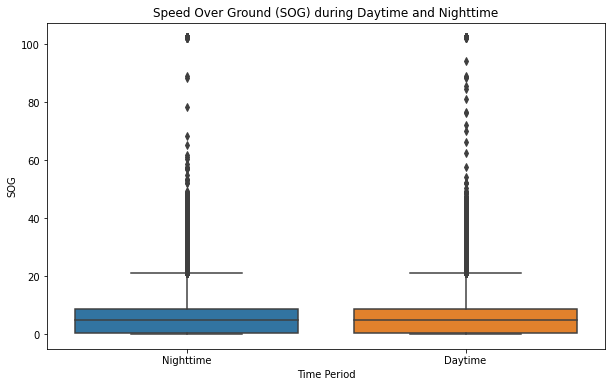

In [0]:
from pyspark.sql.functions import hour
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for SOG > 0
df_ais_june = df_ais_june.filter(df_ais_june.SOG > 0)

# Create a new column to specify whether it's daytime or nighttime
df_ais_june = df_ais_june.withColumn('TimePeriod', F.when((hour(df_ais_june.BaseDateTime) >= 6) & (hour(df_ais_june.BaseDateTime) < 18), 'Daytime').otherwise('Nighttime'))

# Sample a subset of the data for visualization (e.g., 1%)
df_sample = df_ais_june.sample(False, 0.01)

# Convert to pandas DataFrame for visualization
df_sample_pd = df_sample.select('TimePeriod', 'SOG').toPandas()

# Create boxplot for SOG during Daytime and Nighttime
plt.figure(figsize=(10,6))
sns.boxplot(x='TimePeriod', y='SOG', data=df_sample_pd)
plt.title('Speed Over Ground (SOG) during Daytime and Nighttime')
plt.ylabel('SOG')
plt.xlabel('Time Period')
plt.show()

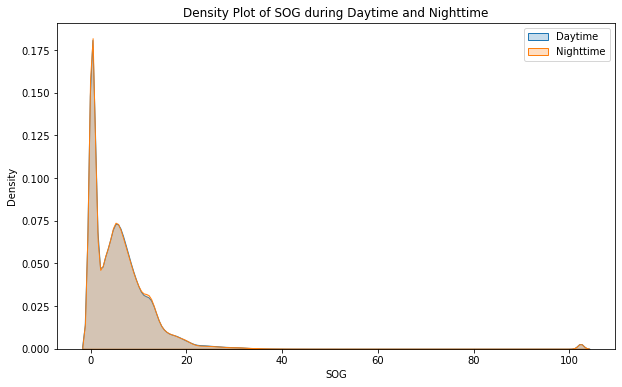

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample a subset of the data for visualization (e.g., 1%)
df_sample = df_ais_june.sample(False, 0.01)

# Convert to pandas DataFrame for visualization
df_sample_pd = df_sample.select('TimePeriod', 'SOG').toPandas()

# Create separate dataframes for Daytime and Nighttime
daytime_sog = df_sample_pd[df_sample_pd['TimePeriod'] == 'Daytime']['SOG']
nighttime_sog = df_sample_pd[df_sample_pd['TimePeriod'] == 'Nighttime']['SOG']

# Plot KDE for SOG during Daytime and Nighttime
plt.figure(figsize=(10,6))
sns.kdeplot(daytime_sog, label='Daytime', shade=True)
sns.kdeplot(nighttime_sog, label='Nighttime', shade=True)
plt.title('Density Plot of SOG during Daytime and Nighttime')
plt.ylabel('Density')
plt.xlabel('SOG')
plt.legend()
plt.show()

In [0]:
from pyspark.sql import functions as F
from pyspark.ml.stat import Summarizer
from scipy.stats import f_oneway

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june")

# Filter out rows with missing or invalid values
df_filtered = df_ais_june.filter(df_ais_june['SOG'].isNotNull() & df_ais_june['VesselType'].isNotNull())

# Group by VesselType and collect SOG values as a list for each group
df_sog_lists = df_filtered.groupBy('VesselType').agg(F.collect_list('SOG').alias('sog_list'))

# Collect the SOG lists as a list of lists
sog_lists = df_sog_lists.select('sog_list').rdd.flatMap(lambda x: x).collect()

# Perform ANOVA test
f_stat, p_value = f_oneway(*sog_lists)

# Print the ANOVA results
print("ANOVA Results:")
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")


ANOVA Results:
F-statistic: 189974.92708543604
P-value: 0.0


The ANOVA results are as follows:

- F-statistic: 189974.92708543604
- P-value: 0.0

The F-statistic measures the ratio of the between-group variability to the within-group variability in the SOG values. A larger F-statistic indicates a greater difference in means between the groups.

The p-value represents the statistical significance of the ANOVA test. A p-value of 0.0 suggests that there is strong evidence to reject the null hypothesis, indicating that there are statistically significant differences in the means of the SOG values across the different VesselTypes.

The ANOVA results indicate that there are significant differences in the average SOG values between at least some of the VesselTypes in the dataset.

In [0]:
from pyspark.sql import functions as F
from scipy.stats import f_oneway

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june")

# Filter out rows with missing or invalid values
df_filtered = df_ais_june.filter(df_ais_june['SOG'].isNotNull() & df_ais_june['VesselType'].isNotNull())

# Group by VesselType and collect SOG values as a list for each group
sog_lists = df_filtered.groupBy('VesselType').agg(F.collect_list('SOG').alias('sog_list')).select('sog_list').rdd.flatMap(lambda x: x).collect()

# Perform ANOVA test
f_stat, p_value = f_oneway(*sog_lists)

# Print the ANOVA results
print("ANOVA Results:")
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")


ANOVA Results:
F-statistic: 189974.92708543845
P-value: 0.0


In [0]:
from pyspark.sql import functions as F
from scipy.stats import ttest_ind

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june")

# Filter out rows with missing or invalid values
df_filtered = df_ais_june.filter(df_ais_june['SOG'].isNotNull() & df_ais_june['VesselType'].isNotNull())

# Split the data into two groups based on VesselType
group_a_sog = df_filtered.filter(df_filtered['VesselType'] == 70).select('SOG').rdd.flatMap(lambda x: x).collect()
group_b_sog = df_filtered.filter(df_filtered['VesselType'] == 80).select('SOG').rdd.flatMap(lambda x: x).collect()

# Perform t-test
t_stat, p_value = ttest_ind(group_a_sog, group_b_sog)

# Print the t-test results
print("T-test Results:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-test Results:
T-statistic: 9.520375236110011
P-value: 1.725695346791911e-21


The t-test results are as follows:

- T-statistic: 9.520375236110011
- P-value: 1.725695346791911e-21

The t-statistic measures the difference in means between the two groups (Group A and Group B) in terms of the standard error. A larger absolute t-statistic value indicates a greater difference in means between the groups.

The p-value represents the statistical significance of the t-test. In this case, the extremely small p-value (close to 0) suggests strong evidence to reject the null hypothesis. It indicates that there is a statistically significant difference in the average SOG values between Group A (VesselType 70) and Group B (VesselType 80).

The t-test results suggest that there is a significant difference in the average SOG values between VesselTypes 70 and 80. The positive t-statistic value indicates that the average SOG value for VesselType 80 is higher than that of VesselType 70, and the small p-value further strengthens the evidence of this difference.

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col
from scipy import stats

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june")

# Define the VesselType filter list
vessel_type_filter = [50, 51, 52, 53, 54, 55, 56, 59, 60, '0X', '1X', '2X', '3X', '4X', '6X', '7X', '8X', '9X']

# Filter out rows with missing or invalid values and the initial VesselType filter
df_filtered = df_ais_june.filter(
    (df_ais_june['SOG'].isNotNull()) &
    (df_ais_june['VesselType'].isNotNull()) &
    (col('VesselType').isin(vessel_type_filter))
)

# Group by VesselType and calculate the average and standard deviation of SOG
df_stats = df_filtered.groupBy('VesselType').agg(
    F.avg('SOG').alias('avg_sog'),
    F.stddev('SOG').alias('std_sog')
)

# Collect the average SOG and standard deviation values as a list for each VesselType
avg_sog_list = df_stats.select('avg_sog').rdd.flatMap(lambda x: x).collect()
std_sog_list = df_stats.select('std_sog').rdd.flatMap(lambda x: x).collect()

# Perform pairwise t-tests for each combination of VesselTypes
p_values = []
vessel_types = df_stats.select('VesselType').rdd.flatMap(lambda x: x).collect()
num_vessel_types = len(vessel_types)

for i in range(num_vessel_types):
    for j in range(i + 1, num_vessel_types):
        vessel_type1 = vessel_types[i]
        vessel_type2 = vessel_types[j]

        sog1 = df_filtered.filter(col('VesselType') == vessel_type1).select('SOG').rdd.flatMap(lambda x: x).collect()
        sog2 = df_filtered.filter(col('VesselType') == vessel_type2).select('SOG').rdd.flatMap(lambda x: x).collect()

        _, p_val = stats.ttest_ind(sog1, sog2)
        p_values.append(p_val)

# Adjust p-values for multiple comparisons using Bonferroni correction
adjusted_p_values = [p_val * len(p_values) for p_val in p_values]

# Print the adjusted p-values for each pairwise comparison
index = 0
for i in range(num_vessel_types):
    for j in range(i + 1, num_vessel_types):
        vessel_type1 = vessel_types[i]
        vessel_type2 = vessel_types[j]
        adjusted_p_value = adjusted_p_values[index]
        index += 1
        print(f"VesselType {vessel_type1} vs VesselType {vessel_type2}: Adjusted p-value = {adjusted_p_value}")


VesselType 53 vs VesselType 52: Adjusted p-value = 4.314317077842753e-18
VesselType 53 vs VesselType 54: Adjusted p-value = 9.457479202701175e-286
VesselType 53 vs VesselType 55: Adjusted p-value = 0.0
VesselType 53 vs VesselType 59: Adjusted p-value = 0.0
VesselType 53 vs VesselType 51: Adjusted p-value = 0.0
VesselType 53 vs VesselType 50: Adjusted p-value = 0.0
VesselType 53 vs VesselType 60: Adjusted p-value = 0.0
VesselType 53 vs VesselType 56: Adjusted p-value = 3.460802104053007e-268
VesselType 52 vs VesselType 54: Adjusted p-value = 1.7630641412817515e-124
VesselType 52 vs VesselType 55: Adjusted p-value = 0.0
VesselType 52 vs VesselType 59: Adjusted p-value = 0.0
VesselType 52 vs VesselType 51: Adjusted p-value = 0.0
VesselType 52 vs VesselType 50: Adjusted p-value = 0.0
VesselType 52 vs VesselType 60: Adjusted p-value = 0.0
VesselType 52 vs VesselType 56: Adjusted p-value = 1.8860634625399716e-85
VesselType 54 vs VesselType 55: Adjusted p-value = 0.0
VesselType 54 vs VesselTy

The output of the code provides the adjusted p-values for each pairwise comparison of VesselTypes. The adjusted p-values are calculated using the Bonferroni correction, which takes into account the multiple comparisons being performed.

Here are a few key points to understand from the output:

- Each line in the output represents a pairwise comparison between two VesselTypes, denoted as "VesselType X vs VesselType Y."
- The adjusted p-value represents the statistical significance of the difference between the two VesselTypes' average SOG (Speed Over Ground) values.
- A lower adjusted p-value indicates a more significant difference between the two VesselTypes' average SOG values.
- An adjusted p-value close to 0 suggests a strong statistical significance, indicating that the average SOG values of the two VesselTypes are likely significantly different.
- An adjusted p-value of 0 means that the difference between the average SOG values is highly statistically significant.

Based on the output, you can observe the significance of the pairwise comparisons between different VesselTypes and gain insights into the differences in their average SOG values.

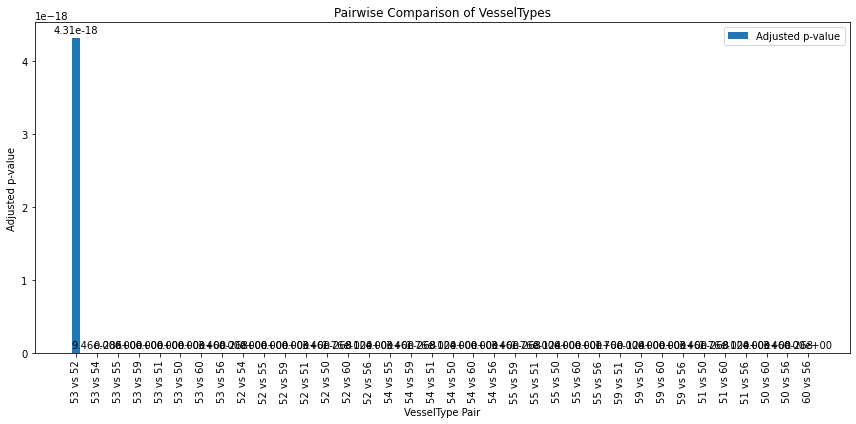

In [0]:
import matplotlib.pyplot as plt

# Prepare data for visualization
vessel_type_pairs = []
p_values = []
for i in range(num_vessel_types):
    for j in range(i + 1, num_vessel_types):
        vessel_type1 = vessel_types[i]
        vessel_type2 = vessel_types[j]
        index = i * (num_vessel_types - i - 1) // 2 + j - i - 1
        vessel_type_pairs.append(f"{vessel_type1} vs {vessel_type2}")
        p_val = adjusted_p_values[index]
        p_values.append(p_val)

# Create the grouped bar chart
x = range(len(vessel_type_pairs))
width = 0.4

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(x, p_values, width, label='Adjusted p-value')

# Add labels, title, and gridlines
ax.set_ylabel('Adjusted p-value')
ax.set_xlabel('VesselType Pair')
ax.set_title('Pairwise Comparison of VesselTypes')
ax.set_xticks(x)
ax.set_xticklabels(vessel_type_pairs, rotation=90)
ax.legend()

# Add values above the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2e}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom')

# Display the chart
plt.tight_layout()
plt.show()